### Sentiment Analysis with Hugging Face & Post Training Quantization (PTQ)

This is a demo on how to perform [post training quantization](https://github.com/intel/neural-compressor/blob/master/docs/Quantization.md) of a [Hugging Face transformer model](https://github.com/huggingface/transformers) using the [Intel® Neural Compressor](https://github.com/intel/neural-compressor). The showcase will be applied to a sentiment analysis task using [SST-2](https://nlp.stanford.edu/sentiment/index.html) data (_Stanford Sentiment Treebank_), i.e., we determine if a sentence has a positive or negative sentiment.

_Nota bene_: This demo is a variation, simplification, and extension of this [Hugging Face](https://github.com/huggingface/notebooks/blob/main/examples/text_classification_quantization_inc.ipynb) demo of Optimum, i.e., Hugging Face's compression tool. 

The demo consists of the following steps:

1. Load and preprocess the dataset
2. Set up, train, and evaluate a full-precision sentiment classification model
3. Quantize the full-precision model & evaluate the quantized model
4. Compare the full-precision and the quantized models wrt accuracy, model size, and inference latency time.

**This demo is executed in a Conda\* environment.**

The environment is the latest [Intel® oneAPI AI Analytics Toolkit](https://software.intel.com/content/www/us/en/develop/tools/oneapi/ai-analytics-toolkit.html) PyTorch* environment, which includes Intel® Optimizations for deep learning workflows. See [here](https://software.intel.com/content/www/us/en/develop/articles/installing-ai-kit-with-conda.html) for more installation information.

If not yet installed, please make sure to uncomment the following lines in order to install Transformers and Datasets from Hugging Face.

In [1]:
! pip install --upgrade pip
! pip install datasets transformers

Install also the Intel® Neural Compressor.

In [2]:
! pip install neural-compressor

**Load necessary packages**

For preprocessing the data, model loading, as well as training and evaluation, Hugging Face's API is used.

For the quantization of the model, we use INC.

In [3]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, default_data_collator, set_seed
from datasets import load_dataset, load_metric

from neural_compressor.experimental import Quantization, common

import torch
import numpy as np
import matplotlib.pyplot as plt

import os

import time

/home/sdp/anaconda3/envs/inc/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Exclude GPUs**

This demo will run on CPUs only.

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = ""

**Define the model together with the tokenizer**

In this case, the default model for sentiment analysis is used, i.e., [DistilBERT](https://huggingface.co/docs/transformers/model_doc/distilbert) which was fine-tuned on SST-2 data ([distilbert-base-uncased-finetuned-sst-2-english](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)). This distilled version of BERT ensures good and effective performance in training and evaluation with a minimal trade-off in accuracy.

The pretrained model as well as the tokenizer will download and subsequently be cached.

Furthermore, we are defining the batch size as well as limit the number of samples used for training for this demo.

In [5]:
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
fp_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = AutoTokenizer.from_pretrained(model_name)

batch_size = 16
max_train_samples = 100

**Load the SST-2 dataset**

We load the SST-2 dataset from the Hugging Face [Dataset](https://github.com/huggingface/datasets) library, using Hugging Face's API. The dataset will be downloaded and subsequently cached.

In [6]:
task = 'sst2'
dataset = load_dataset('glue', task)

2022-09-19 23:49:56 [WARNING] Reusing dataset glue (/home/sdp/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 581.76it/s]


**Load specific metric pertaining to the dataset**

In [7]:
metric = load_metric('glue', task)

**Inspect dataset**

We look quickly into the dataset.

In [8]:
print(dataset['train'][:3]['sentence'])

['hide new secretions from the parental units ', 'contains no wit , only labored gags ', 'that loves its characters and communicates something rather beautiful about human nature ']


**Define preprocessing function for the dataset with the tokenizer**

The raw text data from the dataset will be preprocessed with the respective tokenizer corresponding to the DistilBERT model. 

Preprocessing involves tokenization of the input data, conversion of the tokens to their respective IDs in the pretrained vocabulary, adjustment of the format to the expectation of the model, and the generation of other input values required by the model. Furthermore, the input sequences will be padded.

In [9]:
max_seq_length = min(128, tokenizer.model_max_length)
padding = 'max_length'

def preprocess_function(examples):    
    return tokenizer(examples['sentence'], truncation=True, padding=padding, max_length=max_seq_length)

**Encode dataset with tokenizer**

The map function comes in handy in order to preprocess the full dataset. It maps and applies the preprocess function defined above to each sentence in the dataset. The results are also cached.

In [10]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

2022-09-19 23:49:57 [WARNING] Loading cached processed dataset at /home/sdp/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-335e60022954bacc.arrow
2022-09-19 23:49:57 [WARNING] Loading cached processed dataset at /home/sdp/.cache/huggingface/datasets/glue/sst2/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad/cache-3052123b7a79afff.arrow
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  9.33ba/s]


**Inspect encoded dataset**

Again, we quickly look at the preprocessed data.

In [11]:
print(encoded_dataset['train'][:3])
print('--'*80)
print(f"The dataset's train split consists of {len(encoded_dataset['train'])} sentences.")
print(f"The dataset's validation split consists of {len(encoded_dataset['validation'])} sentences.")
print(f"The dataset's test split consists of {len(encoded_dataset['test'])} sentences.")

{'sentence': ['hide new secretions from the parental units ', 'contains no wit , only labored gags ', 'that loves its characters and communicates something rather beautiful about human nature '], 'label': [0, 0, 1], 'idx': [0, 1, 2], 'input_ids': [[101, 5342, 2047, 3595, 8496, 2013, 1996, 18643, 3197, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 3397, 2053, 15966, 1010, 2069, 4450, 2098, 18201, 2015, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

**Define metric name & training arguments**

In [12]:
metric_name = 'accuracy'

args = TrainingArguments(
    output_dir = 'distilbert_sst2',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    push_to_hub=False,
    dataloader_drop_last=True
)

**Define compute function for the metric**

In [13]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

**Set up the trainer**

In [14]:
set_seed(42)

train_dataset = encoded_dataset['train'].select(range(max_train_samples))

trainer = Trainer(
    fp_model,
    args,
    train_dataset=train_dataset,
    eval_dataset=encoded_dataset['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator = default_data_collator
)

**Train the model**

We train the model for this use case briefly, i.e., 5 epochs, and with a very limited number of training samples (i.e., set as a hyperparameter, cf. above).

In [15]:
start = time.time()
trainer.train()
end = time.time()
print(f"Training took {round(end-start, 2)}s.")

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, idx. If sentence, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/home/sdp/anaconda3/envs/inc/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 100
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.437893,0.901620
2,No log,0.452192,0.900463
3,No log,0.467129,0.902778
4,No log,0.475055,0.901620
5,No log,0.477549,0.901620


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, idx. If sentence, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 872
  Batch size = 16
Saving model checkpoint to distilbert_sst2/checkpoint-6
Configuration saved in distilbert_sst2/checkpoint-6/config.json
Model weights saved in distilbert_sst2/checkpoint-6/pytorch_model.bin
tokenizer config file saved in distilbert_sst2/checkpoint-6/tokenizer_config.json
Special tokens file saved in distilbert_sst2/checkpoint-6/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, idx. If sentence, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.


Training took 42.1s.


**Set up evalutation function & evaluate the newly trained, full-precision model**

In [16]:
metric_name = 'eval_accuracy'

def eval_func(model):
    trainer.model = model
    metrics = trainer.evaluate()
    return metrics.get(metric_name)

l_all = 0
t_all = 0

for _ in range(10):
    
    start = time.time()
    fp_model_result = eval_func(fp_model)
    end = time.time()
    fp_model_eval = end-start

    fp_model_latency = round(round(fp_model_eval, 2)/len(encoded_dataset['validation'])*1000, 2)
    
    l_all += fp_model_latency
    t_all += fp_model_eval

fp_l_avg = round(l_all/10, 2)
fp_t_avg = round(t_all/10, 2)
print(f"The full-precision model has an accuracy of {round(fp_model_result * 100, 2)}%.")
print(f"Evaluation with the full-precision model took in average {fp_t_avg}s.")
print(f"The average latency is: {fp_l_avg}ms.")

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, idx. If sentence, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 872
  Batch size = 16


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, idx. If sentence, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 872
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, idx. If sentence, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 872
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, idx. If sentence, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this messa

The full-precision model has an accuracy of 90.28%.
Evaluation with the full-precision model took in average 3.52s.
The average latency is: 4.03ms.


**Quantization**

We perform [post training static quantization](https://github.com/intel/neural-compressor/blob/master/docs/PTQ.md), from the full-precision FP32 to a reduced precision INT8 model. The quantization procedure needs a yaml config file where the most basic configuration parameters are stored. Also, the evaluation function defined above, as well as calibration data from the dataset are needed.

Usually, quantization results in a smaller model size, and hence, in improved performance at the inference step. However, small trade-offs in the model's accuracy, compared with the full-precision model, can be expected as well.

INC provides foremost automatic accuracy-driven tuning strategies, enabling the user to decide on an acceptable trade-off in accuracy, which can be set individually through the config file. In this example, a conservative, strict approach is chosen, with only a minimal impact on accuracy.

In [17]:
train_dataloader = trainer.get_train_dataloader()

quantizer = Quantization('./conf.yaml')
quantizer.eval_func = eval_func
quantizer.calib_dataloader = train_dataloader
quantizer.model = common.Model(fp_model)

start = time.time()
q_model = quantizer.fit()
end = time.time()
print(f"Quantization took {round(end-start, 2)}s.")

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, idx. If sentence, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
2022-09-19 23:51:15 [INFO] Pass query framework capability elapsed time: 272.3 ms
2022-09-19 23:51:15 [INFO] Get FP32 model baseline.
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, idx. If sentence, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 872
  Batch size = 16
2022-09-19 23:51:18 [INFO] Save tuning history to /home/sdp/inc/nc_workspace/2022-09-19_23-49-53/./history.snapshot.
2022-09-19 23:51:18 [INFO] FP32 baseline is: [Accuracy: 0.9028, Duration (seconds): 3.5228]
2022-09-19 23

Quantization took 10.85s.


**Evaluate the quantized model & compare it with the full-precision model**

In [18]:
l_all = 0
t_all = 0

for _ in range(10):

    start = time.time()
    q_model_result = eval_func(q_model.model)
    end = time.time()
    q_model_eval = end-start

    q_model_latency = round(round(q_model_eval, 2)/len(encoded_dataset['validation'])*1000, 2)
    
    l_all += q_model_latency
    t_all += q_model_eval
    
q_l_avg = round(l_all/10, 2)
q_t_avg = round(t_all/10, 2)
print(f"The quantized model has an accuracy of {round(q_model_result * 100, 2)}%.")
print(f"This results in a drop of {round((fp_model_result - q_model_result) * 100, 2)}% in accuracy when compared to the full-precision model.")
print(f"Evaluation with the quantized model took in average {q_t_avg}s.")
print(f"The average latency is: {q_l_avg}ms.")

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, idx. If sentence, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 872
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, idx. If sentence, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 872
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence, idx. If sentence, idx are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this messa

The quantized model has an accuracy of 90.28%.
This results in a drop of 0.0% in accuracy when compared to the full-precision model.
Evaluation with the quantized model took in average 2.45s.
The average latency is: 2.81ms.


Only a very minimal drop in accuracy can be observed in this example. In order to visualize the difference, we plot the accuracy of the full-precision and the quantized models respectively.

In [19]:
def plotter(outputdict):
    fig = plt.figure(figsize = (10, 5)) 
    plt.bar(outputdict.keys(),outputdict.values(),color='blue',width=0.4)
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.show()

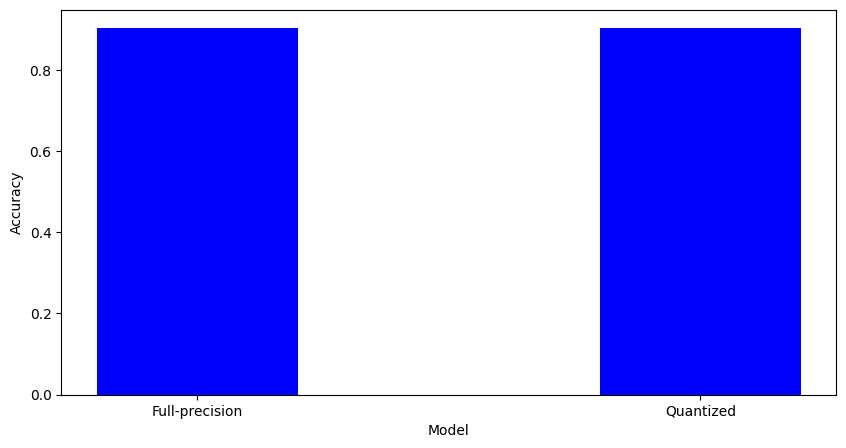

In [20]:
outputDict={"Full-precision":fp_model_result,"Quantized":q_model_result}
plotter(outputDict)

**Compare size of the full-precision and the quantized models**

In [21]:
def get_model_size(model):
    torch.save(model.state_dict(), "tmp.pt")
    model_size = os.path.getsize("tmp.pt") / (1024*1024)
    os.remove("tmp.pt")
    return round(model_size, 2)

fp_model_size = get_model_size(fp_model) 
q_model_size = get_model_size(q_model.model) 

print(f"The full-precision model size is {round(fp_model_size)} MB while the quantized model one is {round(q_model_size)} MB.")
print(f"The quantized model is {round(fp_model_size / q_model_size, 2)}x smaller than the full-precision one.")

The full-precision model size is 255 MB while the quantized model one is 65 MB.
The quantized model is 3.93x smaller than the full-precision one.


A substantial reduction in the model size can be observed in this demo. Again, we plot the differences.

In [22]:
def plotter(outputdict):
    fig = plt.figure(figsize = (10, 5)) 
    plt.bar(outputdict.keys(),outputdict.values(),color='blue',width=0.4)
    plt.xlabel("Model")
    plt.ylabel("Size (MB); lower is better")
    plt.show()

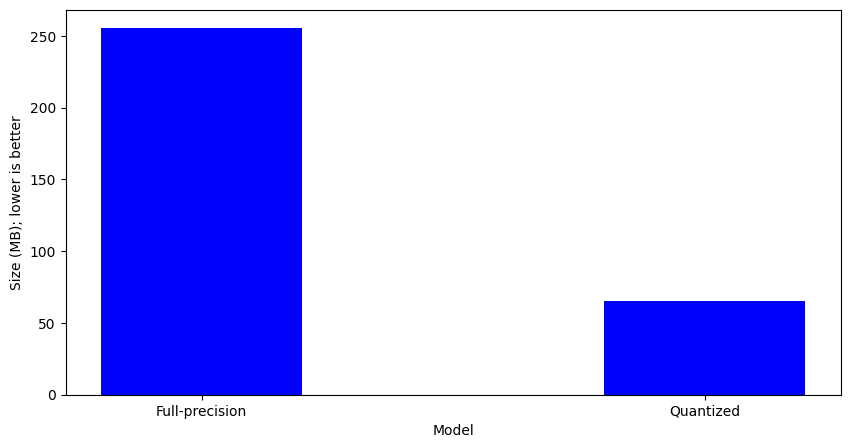

In [23]:
outputDict={"Full-precision":fp_model_size,"Quantized":q_model_size}
plotter(outputDict)

**Compare inference time of the model evalutation**

The simple inference wall times of running the evaluation of the full-precision model and the quantized model are compared and plotted. 

In [24]:
print(f"Evaluation with the full-precision model took in average {fp_t_avg} seconds.")
print(f"Evaluation with the quantized model took in average {q_t_avg} seconds.")

Evaluation with the full-precision model took in average 3.52 seconds.
Evaluation with the quantized model took in average 2.45 seconds.


In [25]:
print(f"Evaluation inference with the quantized model was {round(fp_t_avg/q_t_avg, 2)}x faster.")

Evaluation inference with the quantized model was 1.44x faster.


In [26]:
def plotter(outputdict):
    fig = plt.figure(figsize = (10, 5)) 
    plt.bar(outputdict.keys(),outputdict.values(),color='blue',width=0.4)
    plt.xlabel("Model")
    plt.ylabel("Eval inference (seconds); lower is better")
    plt.show()

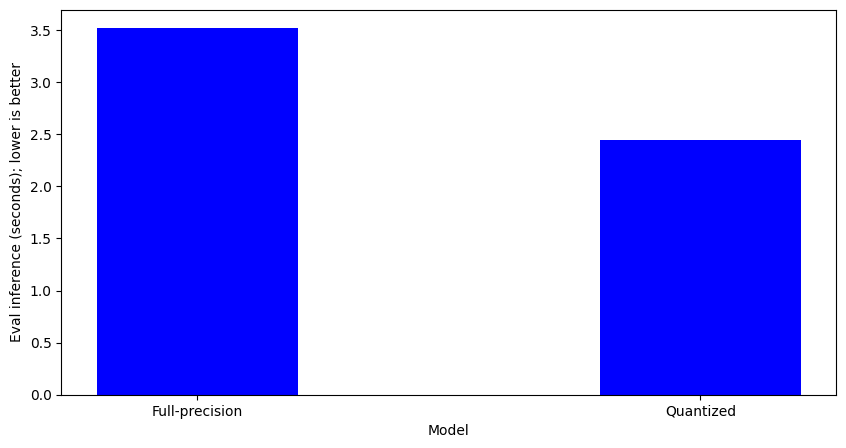

In [27]:
outputDict={"Full-precision":fp_t_avg,"Quantized":q_t_avg}
plotter(outputDict)